# Step: clean in python

In [256]:
import pandas as pd
from matplotlib import cm
from datetime import datetime, timedelta
from numpy import datetime64

pd.set_option('display.max_columns', None)

The core data set is immigration
- at every step we must keep in mind that we will be working with **just a sample** of the immigration data
- all other data sets should be cleaned to the extent that they are relevant to it
- but immigration data refers to its **data dictionary**, and this is what should be cleaned first, because we need to understand it before we can make sense of the immigration data, and clean it first too
- for instance, we can confirm that, indeed, a certain relationship is, say, one-to-many, but confirming that it is one-to-one is not possible, the best we can is express it as an assumption in the **data model**, based on evidence from the data and the domain, and validate it in ETL, and report violations as an error

## Cleaning the immigration data diccionary

In [518]:
i94_raw = pd.read_csv("../../immigration_data_sample.csv")

In [257]:
i94 = pd.read_csv("../../immigration_data_sample.csv")

In [258]:
i94.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1.0,20160422,NaN,NaN,G,O,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1.0,20160423,MTR,NaN,G,R,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,76.0,2.0,1.0,20160407,NaN,NaN,G,O,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,25.0,2.0,1.0,20160428,DOH,NaN,G,O,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,19.0,2.0,1.0,20160406,NaN,NaN,Z,K,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


Scope:
- only air arrivals to USA (including territories)

In [259]:
def only_air(df):
    return df[df['i94mode'] == 1]

In [260]:
def drop_cols(df):
    return df[['cicid', # to detect if duplicates are introduced
                'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate',
               'airline', 'fltno', 'i94addr', 'count'
              ]]

In [261]:
def rename_cols(df):
    return df.rename(columns={
        'i94yr': 'year',
        'i94mon': 'month',
        'i94cit': 'citizenship',
        'i94res': 'residence',
        'i94port': 'port',
        'i94addr': 'us_address'
    })

In [262]:
i94 = (
    i94
    .pipe(only_air)
    .pipe(drop_cols)
    .pipe(rename_cols)
)

In [263]:
i94.head()

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count
0,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,JL,00782,HI,1.0
1,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,*GA,XBLNG,TX,1.0
2,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,LH,00464,FL,1.0
3,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,QR,00739,CA,1.0
5,1481650.0,2016.0,4.0,577.0,577.0,ATL,20552.0,DL,910,GA,1.0


#### Do all passengers in the same flight have the same port?
- That is, is the flight to route relationship one-to-many, or many-to-many?

From the sample, we can tell that, although the evidence is from just two flights, it is **many-to-many**.

In [571]:
def immigration_flight_ports(df):
    return (
        df
        [['arrdate', 'airline', 'fltno', 'i94port']]
        .drop_duplicates()
    )

In [566]:
def immigration_count_flight_ports(df):
    return (
        .groupby(['arrdate', 'airline', 'fltno'])
        .count()
        .rename(columns={'i94port': 'count'})
    )

In [568]:
def immigraton_flights_with_multiple_ports(df):
    return df[df['count'] > 1]

In [593]:
(
    i94_raw
    .pipe(immigration_flight_ports)
    .pipe(immigration_count_flight_ports)
    .pipe(immigraton_flights_with_multiple_ports)
)

,,,count
arrdate,airline,fltno,
20555.0,QF,00007,2
20556.0,KE,00017,2


In [ ]:
flight_pk = ['arrdate', 'airline', 'fltno']

In [603]:
def immigration_flight_with_multiple_ports_passengers(df):
    return (
        df
        .index.to_frame()
        .reset_index(drop=True)
        .merge(i94_raw, left_on=flight_pk, right_on=flight_pk, how='inner')
    )

In [604]:
(
    i94_raw
    .pipe(immigration_flight_ports)
    .pipe(immigration_count_flight_ports)
    .pipe(immigraton_flights_with_multiple_ports)
    .pipe(immigration_flight_with_multiple_ports_passengers)
)

,arrdate,airline,fltno,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,admnum,visatype
0,20555.0,QF,00007,1007931,2051330.0,2016.0,4.0,438.0,438.0,DAL,1.0,FL,20567.0,31.0,2.0,1.0,20160411,NaN,NaN,O,O,NaN,M,1985.0,07092016,NaN,NaN,5.599190e+10,WT
1,20555.0,QF,00007,1008042,2051443.0,2016.0,4.0,438.0,438.0,CHI,1.0,MO,20592.0,72.0,2.0,1.0,20160411,NaN,NaN,G,O,NaN,M,1944.0,07092016,F,NaN,5.599338e+10,WT
2,20556.0,KE,00017,1162298,2369303.0,2016.0,4.0,254.0,276.0,SEA,1.0,NV,20562.0,69.0,2.0,1.0,20160413,NaN,NaN,G,O,NaN,M,1947.0,07112016,F,NaN,5.606443e+10,WT
3,20556.0,KE,00017,1162221,2369222.0,2016.0,4.0,254.0,276.0,SFR,1.0,CA,20563.0,60.0,2.0,1.0,20160413,NaN,NaN,G,O,NaN,M,1956.0,07112016,F,NaN,5.606440e+10,WT


### Clean citizenship and residence

Both of these columns consist just of numbers which have no meaning, and have to be joined with the country mapping information in the i94 data dictionary.

In [264]:
countries = pd.read_csv('../refined/i94countries.csv')

In [265]:
countries

,i94country,country
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA
5,324,ANGOLA
6,529,ANGUILLA
7,518,ANTIGUA-BARBUDA
8,687,ARGENTINA
9,151,ARMENIA


The are no null citizenships no residences in this sample

In [266]:
i94['citizenship'].isnull().value_counts()

False    962
Name: citizenship, dtype: int64

In [267]:
i94['residence'].isnull().value_counts()

False    962
Name: residence, dtype: int64

We will now join with the contries table to get the citizenship and residence country names
- we do left joins so that we know which country codes couldn't be matched to a country name.

In [268]:
def merge_citizenship(df):
    return (
        df.merge(countries, left_on='citizenship', right_on='i94country', how='left')
        .rename(columns={'country': 'cit_country'})
        .drop(columns=['i94country'])
    )

In [269]:
def merge_residence(df):
    return (
        df.merge(countries, left_on='residence', right_on='i94country', how='left')
        .rename(columns={'country': 'res_country'})
        .drop(columns=['i94country'])
    )

In [270]:
i94 = (
    i94
    .pipe(merge_citizenship)
    .pipe(merge_residence)
)

The country name of many visitor's citizenship is unknown (but not null):

In [271]:
i94['cit_country'].isnull().value_counts()

False    839
True     123
Name: cit_country, dtype: int64

On the other hand, all residence codes could be matched to a country name:

In [272]:
i94['res_country'].isnull().value_counts()

False    962
Name: res_country, dtype: int64

Lets explore futher those missing country names.

In [273]:
null_cit = i94[i94['cit_country'].isnull()]

In [274]:
null_cit.head()

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country
2,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,LH,00464,FL,1.0,NaN,GERMANY
12,1387607.0,2016.0,4.0,148.0,112.0,BOS,20552.0,AF,00338,MA,1.0,NaN,GERMANY
16,4668286.0,2016.0,4.0,746.0,158.0,SEA,20568.0,DL,00143,NV,1.0,NaN,RUSSIA
28,5692439.0,2016.0,4.0,133.0,264.0,HOU,20574.0,TK,00033,NV,1.0,NaN,TURKEY
33,6055103.0,2016.0,4.0,252.0,209.0,AGA,20572.0,TW,00311,GU,1.0,NaN,JAPAN


Most seem to be a few such country codes, namelly just 7:

In [275]:
null_cit['citizenship'].value_counts()

148.0    49
254.0    37
252.0    14
746.0    13
133.0     6
734.0     3
718.0     1
Name: citizenship, dtype: int64

Lets make a scatter plot of those with citizenship vs residence to see if there are any patterns, using their codes instead of their names, because the former are numeric:

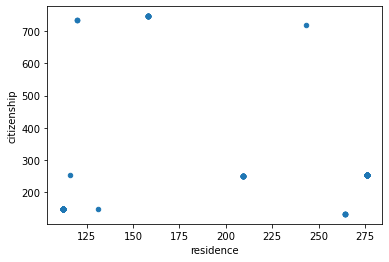

In [276]:
(
    null_cit[['citizenship', 'residence']]
    .plot(kind='scatter', x='residence', y='citizenship')
);

The plot suggests that those unknown country names usually go hand in hand with the same residence countries:

It clearly seems that the bulk of citizenship = 148 reside in Germany, and similar patterns are clear for the other unmatched citizenships.

In [277]:
(
    null_cit[['citizenship', 'res_country', 'count']]
    .groupby(['citizenship', 'res_country'])
    .count()
)

count
citizenship res_country       
133.0       TURKEY           6
148.0       GERMANY         48
            SWITZERLAND      1
252.0       JAPAN           14
254.0       IRELAND          1
            SOUTH KOREA     36
718.0       BURMA            1
734.0       LITHUANIA        3
746.0       RUSSIA          13

It seems justified, from the evidence in this sample, to impute the residence countries to fill in the missing citizenship countries:
- even though in some cases it may result in the same citizenship code being imputed different country names, as would happen in the case of citizenship 148 above
- and, although the sample didn't contain any unmatched residence countries, it seem also reasonable to do the converse

In [278]:
def impute_unmatched_countries(df):
    return df.fillna(value={
        'cit_country': df['res_country'],
        'res_country': df['cit_country']
    })

In [279]:
def check_no_null_cit_country(df):
    return df['cit_country'].isnull().value_counts()

In [280]:
i94 = (
    i94
    .pipe(impute_unmatched_countries)
    #.pipe(check_no_null_cit_country)
)

In [281]:
i94

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country
0,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,JL,00782,HI,1.0,JAPAN,JAPAN
1,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,*GA,XBLNG,TX,1.0,"MEXICO Air Sea, and Not Reported (I-94, no lan...","MEXICO Air Sea, and Not Reported (I-94, no lan..."
2,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,LH,00464,FL,1.0,GERMANY,GERMANY
3,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,QR,00739,CA,1.0,QATAR,QATAR
4,1481650.0,2016.0,4.0,577.0,577.0,ATL,20552.0,DL,910,GA,1.0,GUATEMALA,GUATEMALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,4288772.0,2016.0,4.0,135.0,135.0,LVG,20567.0,VS,00043,NV,1.0,UNITED KINGDOM,UNITED KINGDOM
958,2947585.0,2016.0,4.0,261.0,261.0,PSP,20560.0,SV,00041,HI,1.0,SAUDI ARABIA,SAUDI ARABIA
959,2883298.0,2016.0,4.0,111.0,111.0,MIA,20560.0,AF,00090,FL,1.0,FRANCE,FRANCE
960,2264857.0,2016.0,4.0,582.0,582.0,ATL,20556.0,EV,05510,WI,1.0,"MEXICO Air Sea, and Not Reported (I-94, no lan...","MEXICO Air Sea, and Not Reported (I-94, no lan..."


### Clean port

TODO: there are ports that are not in US, and have no US state, like ['NAS', 'NCA', 'MON', 'VCV', 'TOR', 'MAA', 'HAM']

In [282]:
ports = pd.read_csv('../refined/i94ports.csv')

In [283]:
ports.head()

,Unnamed: 0,i94port,state,city,city_lower
0,0,ALC,AK,Alcan,alcan
1,1,ANC,AK,Anchorage,anchorage
2,2,BAR,AK,Baker Aaf - Baker Island,baker aaf - baker island
3,3,DAC,AK,Daltons Cache,daltons cache
4,4,PIZ,AK,Dew Station Pt Lay Dew,dew station pt lay dew


Check if there are any unmatched ports:
- port city name will be need to match with airports

In [284]:
def merge_ports(df):
    return (
        i94.merge(ports, left_on='port', right_on='i94port', how='left')
        .drop(columns=['Unnamed: 0', 'i94port', 'city_lower'])
        .rename(columns={'state': 'port_state', 'city': 'port_city'})
    )

In [285]:
i94 = (
    i94
    .pipe(merge_ports)
)

No unmatched ports, lets assume port codes always match a port city name

In [286]:
i94['port_city'].isnull().value_counts()

False    962
Name: port_city, dtype: int64

TODO: clearn ports table a bit more, ie "Saipan,"

## Clean arrdate

It is in SAS date format, which is number of days since 1 January 1960:

In [287]:
sas_epoc = datetime(1960, 1, 1)

def arrdate_to_date(df):
    dates = (df['arrdate']
             .apply(lambda sas_date: sas_epoc + timedelta(days=sas_date))
             .astype(datetime64)
    )
    return (df
            .assign(arrdate=dates)
    )

Convert arrdate to a regular date, because then we can apply all the built-in date manipulaton functions.

In [288]:
i94 = (
    i94.
    pipe(arrdate_to_date)
)

In [289]:
i94.head()

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city
0,4084316.0,2016.0,4.0,209.0,209.0,HHW,2016-04-22,JL,00782,HI,1.0,JAPAN,JAPAN,HI,Honolulu
1,4422636.0,2016.0,4.0,582.0,582.0,MCA,2016-04-23,*GA,XBLNG,TX,1.0,"MEXICO Air Sea, and Not Reported (I-94, no lan...","MEXICO Air Sea, and Not Reported (I-94, no lan...",TX,Mcallen
2,1195600.0,2016.0,4.0,148.0,112.0,OGG,2016-04-07,LH,00464,FL,1.0,GERMANY,GERMANY,HI,Kahului - Maui
3,5291768.0,2016.0,4.0,297.0,297.0,LOS,2016-04-28,QR,00739,CA,1.0,QATAR,QATAR,CA,Los Angeles
4,1481650.0,2016.0,4.0,577.0,577.0,ATL,2016-04-08,DL,910,GA,1.0,GUATEMALA,GUATEMALA,GA,Atlanta


It may be possible to assume that all arrdate are in the same month

In [290]:
i94['arrdate'].dt.month.value_counts()

4    962
Name: arrdate, dtype: int64

### Clean airline

Goal: to join immigration airline iata code with an airline names data set.
- assumption: iata airline code and airline name relationship must be one-to-one
- lacking domain knowledge, this assumption is based on the fact that I find it hard to believe that two different airlines from the same country will share the same iata code (unless they actually are the same airline with, say, different names for passenger and cargo services)

The airline names data source was downloaded from openflights.org:

Data dictionary (see https://openflights.org/data.html):
    
- Airline ID:	Unique OpenFlights identifier for this airline.
- Name:	Name of the airline.
- Alias:	Alias of the airline. For example, All Nippon Airways is commonly known as "ANA".
- IATA:	2-letter IATA code, if available.
- ICAO:	3-letter ICAO code, if available.
- Callsign:	Airline callsign.
- Country:	Country or territory where airport is located. See Countries to cross-reference to ISO 3166-1 codes.
- Active:	"Y" if the airline is or has until recently been operational, "N" if it is defunct. This field is not reliable: in particular, major airlines that stopped flying long ago, but have not had their IATA code reassigned (eg. Ansett/AN), will incorrectly show as "Y".

In [291]:
airlines = pd.read_csv('../raw/airlines/airlines.dat', header=None)

In [292]:
airlines.head()

,0,1,2,3,4,5,6,7
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y
2,2,135 Airways,\N,NaN,GNL,GENERAL,United States,N
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,4,2 Sqn No 1 Elementary Flying Training School,\N,NaN,WYT,NaN,United Kingdom,N


In [293]:
def rename_airline_cols(df):
    return df.rename(columns={
        0: 'airline_id',
        1: 'name',
        2: 'alias',
        3: 'iata',
        4: 'icao',
        5: 'callsign',
        6: 'country',
        7: 'active',
    })

In [294]:
def drop_inactive_airlines(df):
    return df[df['active'] == 'Y']

In [295]:
airlines = (
    airlines
    .pipe(rename_airline_cols)
    .pipe(drop_inactive_airlines)
)

In [296]:
airlines

,airline_id,name,alias,iata,icao,callsign,country,active
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
10,10,40-Mile Air,\N,Q5,MLA,MILE-AIR,United States,Y
13,13,Ansett Australia,\N,AN,AAA,ANSETT,Australia,Y
...,...,...,...,...,...,...,...,...
6154,21179,Thai Vietjet Air,NaN,NaN,TVJ,THAIVIET JET,Thailand,Y
6157,21248,GX Airlines,NaN,NaN,CBG,SPRAY,China,Y
6159,21268,Jetgo Australia,NaN,JG,\N,NaN,Australia,Y
6160,21270,Air Carnival,NaN,2S,\N,NaN,India,Y


It seems that we can join using the ```iata``` column:

In [297]:
airlines[airlines['iata'] == 'IB']

,airline_id,name,alias,iata,icao,callsign,country,active
2820,2822,Iberia Airlines,\N,IB,IBE,IBERIA,Spain,Y


But iata codes are not unique:
- this means that the iata code to airline relationship is not one-to-one
- we need a way of disambiguating which airline corresponds to which iata code in the immigration data set

In [298]:
airlines['iata'].value_counts()

G3    3
-     2
I9    2
C3    2
5D    2
     ..
IC    1
QZ    1
IO    1
D6    1
7R    1
Name: iata, Length: 994, dtype: int64

For instance, the following airline iata code is used by 3 different airlines:

In [299]:
airlines[airlines['iata'] == 'G3']

,airline_id,name,alias,iata,icao,callsign,country,active
1789,1790,City Connexion Airlines,\N,G3,CIX,CONNEXION,Burundi,Y
2580,2581,Gol Transportes Aéreos,\N,G3,GLO,GOL TRANSPORTE,Brazil,Y
4366,4374,Sky Express,\N,G3,SEH,AIR CRETE,Greece,Y


Lets now join immigration data with airlines:

In [300]:
def merge_airlines(df):
    return (
        df
        .merge(airlines, left_on='airline', right_on='iata', how='left')
        .drop(columns=['airline_id', 'alias', 'iata', 'icao', 'callsign', 'active'])
        .rename(columns={'name': 'airline_name'})
    )

In [301]:
dup_airlines = (
    i94
    .pipe(merge_airlines)
)

In [302]:
dup_airlines

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city,airline_name,country
0,4084316.0,2016.0,4.0,209.0,209.0,HHW,2016-04-22,JL,00782,HI,1.0,JAPAN,JAPAN,HI,Honolulu,Japan Airlines,Japan
1,4084316.0,2016.0,4.0,209.0,209.0,HHW,2016-04-22,JL,00782,HI,1.0,JAPAN,JAPAN,HI,Honolulu,Japan Airlines Domestic,Japan
2,4422636.0,2016.0,4.0,582.0,582.0,MCA,2016-04-23,*GA,XBLNG,TX,1.0,"MEXICO Air Sea, and Not Reported (I-94, no lan...","MEXICO Air Sea, and Not Reported (I-94, no lan...",TX,Mcallen,NaN,NaN
3,1195600.0,2016.0,4.0,148.0,112.0,OGG,2016-04-07,LH,00464,FL,1.0,GERMANY,GERMANY,HI,Kahului - Maui,Lufthansa,Germany
4,1195600.0,2016.0,4.0,148.0,112.0,OGG,2016-04-07,LH,00464,FL,1.0,GERMANY,GERMANY,HI,Kahului - Maui,Lufthansa Cargo,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,4288772.0,2016.0,4.0,135.0,135.0,LVG,2016-04-23,VS,00043,NV,1.0,UNITED KINGDOM,UNITED KINGDOM,NV,Las Vegas,Virgin Atlantic Airways,United Kingdom
1033,2947585.0,2016.0,4.0,261.0,261.0,PSP,2016-04-16,SV,00041,HI,1.0,SAUDI ARABIA,SAUDI ARABIA,CA,Palm Springs,Saudi Arabian Airlines,Saudi Arabia
1034,2883298.0,2016.0,4.0,111.0,111.0,MIA,2016-04-16,AF,00090,FL,1.0,FRANCE,FRANCE,FL,Miami,Air France,France
1035,2264857.0,2016.0,4.0,582.0,582.0,ATL,2016-04-12,EV,05510,WI,1.0,"MEXICO Air Sea, and Not Reported (I-94, no lan...","MEXICO Air Sea, and Not Reported (I-94, no lan...",GA,Atlanta,Atlantic Southeast Airlines,United States


It seems like duplicates have been introduced (1081 rows when the original sample was 1000):
- this means that some immigration records matched more than one airline, but we desired a one-to-one relationship

The following airline names share the iata code with some other different airlne names.

In [303]:
(
    dup_airlines[dup_airlines['cicid']   # this is where cicid comes in handy, dup detection
    .isin((dup_airlines['cicid'].value_counts() > 1).index)]['airline_name']
    .drop_duplicates()
    .sort_values()
    .to_dict()
)

{53: 'Aer Lingus',
 36: 'Aero VIP (2D)',
 44: 'AeroMéxico',
 58: 'Aeroflot Russian Airlines',
 41: 'Aerolineas Argentinas',
 172: 'Air Berlin',
 746: 'Air Busan',
 42: 'Air China',
 757: 'Air Europa',
 14: 'Air France',
 207: 'Air India Limited',
 416: 'Air Japan',
 56: 'Air New Zealand',
 722: 'Air Pacific',
 142: 'Alitalia',
 111: 'All Nippon Airways',
 10: 'American Airlines',
 399: 'American Eagle Airlines',
 19: 'Asiana Airlines',
 101: 'Atlantic Southeast Airlines',
 959: 'Austrian Airlines',
 70: 'Avianca - Aerovias Nacionales de Colombia',
 17: 'Azul',
 509: 'Bahamasair',
 8: 'British Airways',
 565: 'Brussels Airlines',
 641: 'Canadian Airlines',
 197: 'Caribbean Airlines',
 839: 'Caspian Airlines',
 7: 'Cathay Pacific',
 333: 'Cayman Airways',
 718: 'Cebu Pacific',
 117: 'China Airlines',
 15: 'China Eastern Airlines',
 284: 'China Southern Airlines',
 642: 'Compass Airlines',
 57: 'Copa Airlines',
 6: 'Delta Air Lines',
 121: 'EVA Air',
 187: 'Edelweiss Air',
 476: 'Egyptair

This presents a new data cleaning challenge (entity resolution): how to decide which immigration airline iata code to match to which airline?
- the possible solution that I will explore is to use the airline routes data set from openflights.org
- assumption: the airline iata code that has the most routes from an airport in a given country is based in that country
- then we can use that information to disambiguate which airline we will assume the immigratoni iata code refers to
- assumption: if said iata code still refers to two different airlines in the same country, they are in fact the same airline (passengers and cargo divisions, for instance)
- TODO: explore other entity resolution techniques

In [304]:
routes_raw = pd.read_csv('../raw/airlines/routes.dat', header=None)

In [305]:
routes_raw

,0,1,2,3,4,5,6,7,8
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
...,...,...,...,...,...,...,...,...,...
67658,ZL,4178,WYA,6334,ADL,3341,NaN,0,SF3
67659,ZM,19016,DME,4029,FRU,2912,NaN,0,734
67660,ZM,19016,FRU,2912,DME,4029,NaN,0,734
67661,ZM,19016,FRU,2912,OSS,2913,NaN,0,734


In [306]:
def drop_routes_columns(df):
    return (
        df[[0, 2, 4]]
        .rename(columns={0: 'iata', 2: 'origin', 4: 'destination'})
    )

In [307]:
routes = routes_raw.pipe(drop_routes_columns)

In [308]:
routes.head()

,iata,origin,destination
0,2B,AER,KZN
1,2B,ASF,KZN
2,2B,ASF,MRV
3,2B,CEK,KZN
4,2B,CEK,OVB


In [309]:
airports2 = pd.read_csv('../raw/airlines/airports.dat', header=None)

In [310]:
airports2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7693,14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298,272,\N,\N,\N,airport,OurAirports
7694,14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999,1670,\N,\N,\N,airport,OurAirports
7695,14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000,85,\N,\N,\N,airport,OurAirports
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,\N,\N,\N,airport,OurAirports


How many routes originate in a given country for each airline?

In [311]:
def drop_airports2_columns(df):
    return df[[3, 4]].rename(columns={3: 'origin_country', 4: 'origin'})

In [312]:
def merge_routes(df):
    return (
        df
        .merge(routes, left_on='origin', right_on='origin', how='inner')
    )

In [313]:
def calc_country_airline_counts(df):
    return (
        df
        .groupby(['iata', 'origin_country'])
        .count()
        ['origin']
        .rename('count')
        .reset_index()
)

In [314]:
airline_country_counts = (
    airports2
    .pipe(drop_airports2_columns)
    .pipe(merge_routes)
    .pipe(calc_country_airline_counts)
)

For instance, airline with code 2B has 41 flight originating in Russia, and only 1 in Azerbaijan. My bet is that this means that it is a Russian airline.

In [315]:
airline_country_counts.head()

,iata,origin_country,count
0,2B,Azerbaijan,1
1,2B,Russia,41
2,2G,Russia,21
3,2I,Peru,18
4,2J,Benin,2


As a first step in determining which country has the most routes for each airline, determine, for each airline, what is the max number of routes that originate from any country:

In [316]:
def calc_max_country_airline_count(df):
    return (
        df
        .groupby(['iata'])
        .max('count')
        .reset_index()
)

In [317]:
max_airline_country_count = (
    airline_country_counts
    .pipe(calc_max_country_airline_count)
)

In [318]:
max_airline_country_count.head()

,iata,count
0,2B,41
1,2G,21
2,2I,18
3,2J,10
4,2K,9


Now we can determine which is the origin country with the max number of routes for airline:

In [319]:
def calc_max_airline_country(df):
    return df.merge(
        max_airline_country_count,
        left_on=['iata', 'count'],
        right_on=['iata', 'count'],
        how='inner'
    )

In [320]:
max_airline_country = (
    airline_country_counts
    .pipe(calc_max_airline_country)
)

In [321]:
max_airline_country.head()

,iata,origin_country,count
0,2B,Russia,41
1,2G,Russia,21
2,2I,Peru,18
3,2J,Burkina Faso,10
4,2K,Ecuador,9


The next step is to join the above with the airline data, to enforce a one-to-one airline iata code to airline (name) relationship:

In [322]:
def merge_max_airline_country(df):
    return df.merge(
        max_airline_country,
        left_on=['iata', 'country'],
        right_on=['iata', 'origin_country'],
        how='inner'
    )

As mentioned above, if there are still any ambiguities, it is assumed that the name of either airline that has the same iata code is contained in the other:
- for instance, "Lufthansa" and "Lufthansa Cargo"

In [323]:
def string_overlap(s1, s2):
    if s1.find(s2) != -1:
        return s2
    elif s2.find(s1) != -1:
        return s1
    else:
        return None

In [324]:
def choose_airline_name(row, ambigous_iatas, airlines_df):
    iata = row['iata']
    if iata in ambigous_iatas:
        name = row['name']
        other_name = airlines_df[(airlines_df['iata'] == iata) & (airlines_df['name'] != name)]['name']
        return string_overlap(str(name), str(other_name)) == name
    return True

In [325]:
def disambiguate_airline_name(df):
    counts = df.groupby(['iata', 'country', 'origin_country']).count()['count']
    ambigous_iatas = counts[(counts > 1)].reset_index()['iata'].to_list()
    keep = df.apply(axis=1, func=lambda row: choose_airline_name(row, ambigous_iatas, df))
    return df[keep]

In [326]:
airlines = (
    airlines
    .pipe(merge_max_airline_country)
    .pipe(disambiguate_airline_name)
)

In [327]:
pd.set_option('display.max_rows', airlines.shape[0]+1)

In [328]:
airlines.sort_values('count', ascending=False)

,airline_id,name,alias,iata,icao,callsign,country,active,origin_country,count
2,24,American Airlines,\N,AA,AAL,AMERICAN,United States,Y,United States,1745
278,5209,United Airlines,\N,UA,UAL,UNITED,United States,Y,United States,1662
105,2009,Delta Air Lines,\N,DL,DAL,DELTA,United States,Y,United States,1603
280,5265,US Airways,\N,US,USA,U S AIR,United States,Y,United States,1602
93,1767,China Southern Airlines,\N,CZ,CSN,CHINA SOUTHERN,China,Y,China,1295
241,4547,Southwest Airlines,\N,WN,SWA,SOUTHWEST,United States,Y,United States,1136
92,1758,China Eastern Airlines,\N,MU,CES,CHINA EASTERN,China,Y,China,1071
49,751,Air China,\N,CA,CCA,AIR CHINA,China,Y,China,1066
247,4611,Shenzhen Airlines,\N,ZH,CSZ,SHENZHEN AIR,China,Y,China,786
69,1316,AirTran Airways,\N,FL,TRS,CITRUS,United States,Y,United States,699


See which top airline were missed if any
- I consider top airlines those that have the most routes

In [329]:
top_airlines = (
    routes
    .groupby('iata')
    .count()['origin']
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'origin': 'count'})
)

In [330]:
top_airlines.head()

,iata,count
0,FR,2484
1,AA,2354
2,UA,2180
3,DL,1981
4,US,1960


In [331]:
top_airlines.merge(airlines, left_on='iata', right_on='iata', how='left')

,iata,count_x,airline_id,name,alias,icao,callsign,country,active,origin_country,count_y
0,FR,2484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AA,2354,24.0,American Airlines,\N,AAL,AMERICAN,United States,Y,United States,1745.0
2,UA,2180,5209.0,United Airlines,\N,UAL,UNITED,United States,Y,United States,1662.0
3,DL,1981,2009.0,Delta Air Lines,\N,DAL,DELTA,United States,Y,United States,1603.0
4,US,1960,5265.0,US Airways,\N,USA,U S AIR,United States,Y,United States,1602.0
...,...,...,...,...,...,...,...,...,...,...,...
563,H7,2,2094.0,Eagle Air,\N,NaN,NaN,Uganda,Y,Uganda,2.0
564,4B,2,20565.0,Boutique Air (Priv),NaN,BTQ,NaN,United States,Y,United States,2.0
565,6I,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
566,9D,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
# TODO: Air France is missing, unnaceptable, have a second look

Join airlines with immigration data

In [333]:
def join_immigration_with_airlines(df):
    return (
        df
        .merge(airlines[['name', 'iata']], left_on='airline', right_on='iata', how='left')
        .rename(columns={'name': 'airline_name'})
        .drop(columns=['iata'])
    )

In [334]:
i94 = (
    i94
    .pipe(join_immigration_with_airlines)
)

In [335]:
i94

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city,airline_name
0,4084316.0,2016.0,4.0,209.0,209.0,HHW,2016-04-22,JL,00782,HI,1.0,JAPAN,JAPAN,HI,Honolulu,Japan Airlines
1,4422636.0,2016.0,4.0,582.0,582.0,MCA,2016-04-23,*GA,XBLNG,TX,1.0,"MEXICO Air Sea, and Not Reported (I-94, no lan...","MEXICO Air Sea, and Not Reported (I-94, no lan...",TX,Mcallen,NaN
2,1195600.0,2016.0,4.0,148.0,112.0,OGG,2016-04-07,LH,00464,FL,1.0,GERMANY,GERMANY,HI,Kahului - Maui,Lufthansa
3,5291768.0,2016.0,4.0,297.0,297.0,LOS,2016-04-28,QR,00739,CA,1.0,QATAR,QATAR,CA,Los Angeles,Qatar Airways
4,1481650.0,2016.0,4.0,577.0,577.0,ATL,2016-04-08,DL,910,GA,1.0,GUATEMALA,GUATEMALA,GA,Atlanta,Delta Air Lines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,4288772.0,2016.0,4.0,135.0,135.0,LVG,2016-04-23,VS,00043,NV,1.0,UNITED KINGDOM,UNITED KINGDOM,NV,Las Vegas,NaN
958,2947585.0,2016.0,4.0,261.0,261.0,PSP,2016-04-16,SV,00041,HI,1.0,SAUDI ARABIA,SAUDI ARABIA,CA,Palm Springs,Saudi Arabian Airlines
959,2883298.0,2016.0,4.0,111.0,111.0,MIA,2016-04-16,AF,00090,FL,1.0,FRANCE,FRANCE,FL,Miami,Air France
960,2264857.0,2016.0,4.0,582.0,582.0,ATL,2016-04-12,EV,05510,WI,1.0,"MEXICO Air Sea, and Not Reported (I-94, no lan...","MEXICO Air Sea, and Not Reported (I-94, no lan...",GA,Atlanta,NaN


### Clean fltno

It might be useful to match the flight number in the immigration data to the routes data set.

Lets start by determining how frequently it is null, which, it seems, is very rare:

In [336]:
i94['fltno'].isnull().value_counts()

False    961
True       1
Name: fltno, dtype: int64

In [337]:
i94[i94['fltno'].isnull()]

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city,airline_name
845,6046172.0,2016.0,4.0,254.0,276.0,SAI,2016-04-25,OZ,NaN,NaN,1.0,SOUTH KOREA,SOUTH KOREA,PN,"Saipan,",NaN


Can't be joined with openflight.org's routes data set, which doesn't have the flight number.

### Clean us_address

In [338]:
i94['us_address'].value_counts()

FL    187
CA    159
NY    157
HI     52
TX     39
NV     34
IL     30
GU     27
MA     26
NJ     20
GA     19
WA     14
VA     13
MD     11
NE     11
DC     11
PA     10
MI      9
NC      9
LA      8
TN      7
IN      7
CT      6
OH      5
CO      5
AL      5
AZ      5
MN      3
MP      3
SC      3
VT      2
UN      2
MO      2
UT      1
RI      1
AR      1
OR      1
TE      1
NH      1
OK      1
MS      1
NM      1
SW      1
PR      1
IA      1
KS      1
ID      1
KY      1
WI      1
Name: us_address, dtype: int64

To get the state name we can join with the states table in the immigration dictionary:

In [339]:
states = pd.read_csv('../refined/states.csv')

In [340]:
states

,state,state_name
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California
5,CO,Colorado
6,CT,Connecticut
7,DE,Delaware
8,DC,District of Columbia
9,FL,Florida


In [341]:
def merge_with_states(df):
    return df.merge(states, left_on='us_address', right_on='state')

In [342]:
def fix_state_cols(df):
    return (
        df
        .rename(columns={'state_name': 'us_address_state'})
        .drop(columns=['state'])
    )

In [343]:
i94 = (
    i94
    .pipe(merge_with_states)
    .pipe(fix_state_cols)
)

To join the temperature data set on the us_address we need to join it first with the state table (extracted from the immigration data dictionary), to match the state name with the state code:

#### Clean temperatures

In [344]:
temperatures_raw = pd.read_csv("../../GlobalLandTemperaturesByState.csv")

In [345]:
temperatures_raw.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


We are only interested in US states temperatures:

In [346]:
def filter_usa(df):
    return df[df['Country'] == 'United States']

There is a problem with Georgia and District of Columbia, which are respectively named Georgia (State) and District Of Columbia (note the capital O) in the temperatures data set:

In [347]:
def distinct_states(df):
    return df['State'].drop_duplicates()

In [348]:
(
    temperatures_raw
    .pipe(filter_usa)
    .pipe(distinct_states)
)

7458                   Alabama
12878                   Alaska
32008                  Arizona
34153                 Arkansas
71058               California
96604                 Colorado
98929              Connecticut
110201                Delaware
116053    District Of Columbia
123791                 Florida
131421         Georgia (State)
153157                  Hawaii
167979                   Idaho
170282                Illinois
173521                 Indiana
179567                    Iowa
214108                  Kansas
228059                Kentucky
276390               Louisiana
286896                   Maine
298686                Maryland
301925           Massachusetts
312139                Michigan
317559               Minnesota
320798             Mississippi
323865                Missouri
329717                 Montana
347985                Nebraska
356483                  Nevada
361946           New Hampshire
365185              New Jersey
368424              New Mexico
372822  

Lets standardize those state names to make joins possible:

In [349]:
def standardize_states(df):
    to_replace = {
        'State': {
            'District Of Columbia': 'District of Columbia',
            'Georgia (State)': 'Georgia'
        }
    }
    return df.replace(to_replace=to_replace)

In [350]:
(
    temperatures_raw
    .pipe(filter_usa)
    .pipe(standardize_states)
    .pipe(distinct_states)
)

7458                   Alabama
12878                   Alaska
32008                  Arizona
34153                 Arkansas
71058               California
96604                 Colorado
98929              Connecticut
110201                Delaware
116053    District of Columbia
123791                 Florida
131421                 Georgia
153157                  Hawaii
167979                   Idaho
170282                Illinois
173521                 Indiana
179567                    Iowa
214108                  Kansas
228059                Kentucky
276390               Louisiana
286896                   Maine
298686                Maryland
301925           Massachusetts
312139                Michigan
317559               Minnesota
320798             Mississippi
323865                Missouri
329717                 Montana
347985                Nebraska
356483                  Nevada
361946           New Hampshire
365185              New Jersey
368424              New Mexico
372822  

It seems like there is one temperature per month, the first day; which is confirmed:
- this means that we can assume that there is at most one temperature record per year/day/month/state

In [351]:
def temp_days(df):
    return df['dt'].str[-2:]

In [352]:
(
    temperatures_raw
    .pipe(filter_usa)
    .pipe(temp_days)
    .pipe(temperatures_raw.value_counts)
)

dt
01    149745
dtype: int64

USA state temperatures are available only until september 2013:
- TODO find more recent data, or use ML to predict later temps

In [353]:
def latest_temps(df):
    return df.set_index(['dt', 'State']).sort_index(ascending=False)

In [354]:
(
    temperatures_raw
    .pipe(filter_usa)
    .pipe(latest_temps)
)

AverageTemperature  \
dt         State                                      
2013-09-01 Wyoming                           15.811   
           Wisconsin                         16.567   
           West Virginia                     18.708   
           Washington                        16.823   
           Virginia                          20.219   
...                                             ...   
1743-11-01 Florida                           17.694   
           District Of Columbia               5.339   
           Delaware                           6.127   
           Connecticut                        3.818   
           Alabama                           10.722   

                                 AverageTemperatureUncertainty        Country  
dt         State                                                               
2013-09-01 Wyoming                                       1.101  United States  
           Wisconsin                                     0.982  United States  
           West Virginia                                 0.909  United States  
           Washington                                    1.128  United States  
           Virginia                                      0.969  United States  
...                                                        ...            ...  
1743-11-01 Florida                                       2.514  United States  
           District Of Columbia                          2.247  United States  
           Delaware                                      2.050  United States  
           Connecticut                                   1.727  United States  
           Alabama                                       2.898  United States  

[149745 rows x 3 columns]

Given that we need a years worth of temperatures, lets check 2012:

In [355]:
def temps_2012(df):
    return df[df['dt'].str[0:4] == '2012']

There are temperatures for 51 USA states:

In [356]:
def count_states(df):
    return len(df['State'].drop_duplicates())

We expected the latest full year to contain 612 temperatures:
- given that there is at most one temperature record per year/day/month/state

In [357]:
51 * 12

612

And, indeed, 2012 has 612 temperatures
- TODO find more recent data, or use ML to predict later temps

In [358]:
(
    temperatures_raw
    .pipe(filter_usa)
    .pipe(temps_2012)
)

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
10676,2012-01-01,10.290,0.303,Alabama,United States
10677,2012-02-01,11.405,0.201,Alabama,United States
10678,2012-03-01,18.401,0.124,Alabama,United States
10679,2012-04-01,18.675,0.265,Alabama,United States
10680,2012-05-01,23.512,0.225,Alabama,United States
...,...,...,...,...,...
626426,2012-08-01,19.468,0.245,Wyoming,United States
626427,2012-09-01,14.491,0.221,Wyoming,United States
626428,2012-10-01,5.455,0.264,Wyoming,United States
626429,2012-11-01,1.884,0.139,Wyoming,United States


Lets clean the temperature data set:

Extract year and month from date:

In [359]:
def fix_date(df):
    year=df['dt'].str[:4].astype(int)
    month=df['dt'].str[5:7].astype(int)
    return df.assign(year=year, month=month)

One decimal temperature precision is enough:

In [360]:
def round_temp(df):
    return df.round({'temperature': 1})

In [361]:
def fix_cols(df):
    return (
        df
        .rename(columns={'AverageTemperature': 'temperature', 'State': 'state_name'})
        .drop(columns=['dt', 'AverageTemperatureUncertainty', 'Country'])
    )

Join with states, to have the state code available for joining with other data:

In [362]:
def merge_temp_states(df):
    return df.merge(states, left_on='state_name', right_on='state_name', how='left')

In [363]:
def reorder_temp_cols(df):
    return df[['year', 'month', 'state', 'state_name', 'temperature']]

This the clean temperatures data:

In [364]:
temperatures = (
    temperatures_raw
    .pipe(filter_usa)
    .pipe(temps_2012)
    .pipe(standardize_states)
    .pipe(fix_date)
    .pipe(fix_cols)
    .pipe(round_temp)
    .pipe(merge_temp_states)
    .pipe(reorder_temp_cols)
)

In [365]:
temperatures

,year,month,state,state_name,temperature
0,2012,1,AL,Alabama,10.3
1,2012,2,AL,Alabama,11.4
2,2012,3,AL,Alabama,18.4
3,2012,4,AL,Alabama,18.7
4,2012,5,AL,Alabama,23.5
...,...,...,...,...,...
607,2012,8,WY,Wyoming,19.5
608,2012,9,WY,Wyoming,14.5
609,2012,10,WY,Wyoming,5.5
610,2012,11,WY,Wyoming,1.9


We can now join the immigration and temperature tables to match address states to their temperatures:
- TODO in the first pass just have a static temperature for each state

In [366]:
def merge_temperatures(df, state_col):
    return (
        df.
        merge(
            temperatures.drop(columns=['year']), 
            left_on=['month', state_col], 
            right_on=['month', 'state'], 
            how='left'
        )
    )

In [367]:
def rename_temperature(df, new_name):
    return (
        df
        .rename(columns={'temperature': new_name})
    )

In [368]:
def drop_state(df):
    return df.drop(columns=['state', 'state_name'])

In [369]:
(
    i94
    .pipe(lambda df: merge_temperatures(df, 'us_address'))
    .pipe(lambda df: rename_temperature(df, 'address_temperature'))
    .pipe(drop_state)
)

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city,airline_name,us_address_state,address_temperature
0,4084316.0,2016.0,4.0,209.0,209.0,HHW,2016-04-22,JL,00782,HI,1.0,JAPAN,JAPAN,HI,Honolulu,Japan Airlines,Hawaii,21.3
1,5056736.0,2016.0,4.0,209.0,209.0,PHI,2016-04-27,DL,00598,HI,1.0,JAPAN,JAPAN,PA,Philadelphia,Delta Air Lines,Hawaii,21.3
2,2139030.0,2016.0,4.0,689.0,689.0,PSP,2016-04-11,AA,00962,HI,1.0,BRAZIL,BRAZIL,CA,Palm Springs,American Airlines,Hawaii,21.3
3,2721962.0,2016.0,4.0,209.0,209.0,NEW,2016-04-15,HA,00458,HI,1.0,JAPAN,JAPAN,NJ,Newark/teterboro,Hawaiian Airlines,Hawaii,21.3
4,3364934.0,2016.0,4.0,245.0,245.0,PSP,2016-04-18,MU,00571,HI,1.0,"CHINA, PRC","CHINA, PRC",CA,Palm Springs,China Eastern Airlines,Hawaii,21.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,5011988.0,2016.0,4.0,746.0,158.0,NYC,2016-04-26,SU,00102,NH,1.0,RUSSIA,RUSSIA,NY,New York,Aeroflot Russian Airlines,New Hampshire,7.1
878,5270782.0,2016.0,4.0,213.0,213.0,NYC,2016-04-28,EK,00201,OR,1.0,INDIA,INDIA,NY,New York,Emirates,Oregon,7.9
879,80898.0,2016.0,4.0,261.0,261.0,DET,2016-04-01,AA,00051,AR,1.0,SAUDI ARABIA,SAUDI ARABIA,MI,Detroit,American Airlines,Arkansas,18.1
880,5446642.0,2016.0,4.0,131.0,131.0,NYC,2016-04-29,LX,00016,RI,1.0,SWITZERLAND,SWITZERLAND,NY,New York,Swiss International Air Lines,Rhode Island,9.7


Join again with temperatures to add port state temperatures:

In [370]:
i94 = (
    i94
    .pipe(lambda df: merge_temperatures(df, 'us_address'))
    .pipe(lambda df: rename_temperature(df, 'address_temperature'))
    .pipe(drop_state)
    .pipe(lambda df: merge_temperatures(df, 'port_state'))
    .pipe(lambda df: rename_temperature(df, 'port_temperature'))
    .pipe(drop_state)
)

In [371]:
i94

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city,airline_name,us_address_state,address_temperature,port_temperature
0,4084316.0,2016.0,4.0,209.0,209.0,HHW,2016-04-22,JL,00782,HI,1.0,JAPAN,JAPAN,HI,Honolulu,Japan Airlines,Hawaii,21.3,21.3
1,5056736.0,2016.0,4.0,209.0,209.0,PHI,2016-04-27,DL,00598,HI,1.0,JAPAN,JAPAN,PA,Philadelphia,Delta Air Lines,Hawaii,21.3,9.0
2,2139030.0,2016.0,4.0,689.0,689.0,PSP,2016-04-11,AA,00962,HI,1.0,BRAZIL,BRAZIL,CA,Palm Springs,American Airlines,Hawaii,21.3,13.5
3,2721962.0,2016.0,4.0,209.0,209.0,NEW,2016-04-15,HA,00458,HI,1.0,JAPAN,JAPAN,NJ,Newark/teterboro,Hawaiian Airlines,Hawaii,21.3,11.2
4,3364934.0,2016.0,4.0,245.0,245.0,PSP,2016-04-18,MU,00571,HI,1.0,"CHINA, PRC","CHINA, PRC",CA,Palm Springs,China Eastern Airlines,Hawaii,21.3,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,5011988.0,2016.0,4.0,746.0,158.0,NYC,2016-04-26,SU,00102,NH,1.0,RUSSIA,RUSSIA,NY,New York,Aeroflot Russian Airlines,New Hampshire,7.1,7.1
878,5270782.0,2016.0,4.0,213.0,213.0,NYC,2016-04-28,EK,00201,OR,1.0,INDIA,INDIA,NY,New York,Emirates,Oregon,7.9,7.1
879,80898.0,2016.0,4.0,261.0,261.0,DET,2016-04-01,AA,00051,AR,1.0,SAUDI ARABIA,SAUDI ARABIA,MI,Detroit,American Airlines,Arkansas,18.1,6.6
880,5446642.0,2016.0,4.0,131.0,131.0,NYC,2016-04-29,LX,00016,RI,1.0,SWITZERLAND,SWITZERLAND,NY,New York,Swiss International Air Lines,Rhode Island,9.7,7.1


All immigration rows be joined to an address temperature:

In [372]:
i94['address_temperature'].isnull().value_counts()

False    882
Name: address_temperature, dtype: int64

But not all could be joined to a port temperature:

In [373]:
i94['port_temperature'].isnull().value_counts()

False    867
True      15
Name: port_temperature, dtype: int64

Lets have closer look:

In [374]:
def missing_port_temps(df):
    return df[df['port_temperature'].isnull()]

In [375]:
(
    i94
    .pipe(missing_port_temps)
)

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city,airline_name,us_address_state,address_temperature,port_temperature
190,2759806.0,2016.0,4.0,512.0,512.0,NAS,2016-04-15,UP,237,FL,1.0,BAHAMAS,BAHAMAS,AS,"Nassau, Bah",Bahamasair,Florida,22.1,NaN
215,5032769.0,2016.0,4.0,129.0,129.0,NAS,2016-04-27,YX,04335,FL,1.0,SPAIN,SPAIN,AS,"Nassau, Bah",NaN,Florida,22.1,NaN
258,5707240.0,2016.0,4.0,135.0,135.0,NAS,2016-04-30,YX,04427,FL,1.0,UNITED KINGDOM,UNITED KINGDOM,AS,"Nassau, Bah",NaN,Florida,22.1,NaN
263,3481453.0,2016.0,4.0,696.0,696.0,NCA,2016-04-18,ARU,821,FL,1.0,VENEZUELA,VENEZUELA,AN,"North Caicos, Turk & Ca",NaN,Florida,22.1,NaN
273,5018908.0,2016.0,4.0,111.0,111.0,MON,2016-04-27,RV,01606,FL,1.0,FRANCE,FRANCE,DA,"Montreal, Ca",NaN,Florida,22.1,NaN
287,2955388.0,2016.0,4.0,438.0,438.0,VCV,2016-04-16,UA,00595,CA,1.0,AUSTRALIA,AUSTRALIA,DA,"Vancouver, Ca",United Airlines,California,13.5,NaN
406,4729596.0,2016.0,4.0,245.0,206.0,VCV,2016-04-25,RV,01884,CA,1.0,"CHINA, PRC",HONG KONG,DA,"Vancouver, Ca",NaN,California,13.5,NaN
423,1364080.0,2016.0,4.0,123.0,123.0,TOR,2016-04-08,9E,03848,CA,1.0,NETHERLANDS,NETHERLANDS,DA,"Toronto, Ca",Pinnacle Airlines,California,13.5,NaN
438,1056530.0,2016.0,4.0,512.0,512.0,NAS,2016-04-06,DL,00554,GA,1.0,BAHAMAS,BAHAMAS,AS,"Nassau, Bah",Delta Air Lines,Georgia,19.1,NaN
584,712131.0,2016.0,4.0,438.0,438.0,TOR,2016-04-04,AA,04104,NY,1.0,AUSTRALIA,AUSTRALIA,DA,"Toronto, Ca",American Airlines,New York,7.1,NaN


The reason is that some port states are not, in fact, US states:

In [376]:
def port_states(df):
    return df['port_state'].drop_duplicates().to_frame()

In [377]:
def missing_port_states(df):
    return df[df['port_state'].isnull()]

In [378]:
(
    i94
    .pipe(missing_port_temps)
    .pipe(missing_port_states)
)

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city,airline_name,us_address_state,address_temperature,port_temperature


Lets join these states with the ports table:

In [379]:
def merge_unique_ports(df):
    return (
        df.merge(ports, left_on='port_state', right_on='state', how='left')
        .drop_duplicates()
    )

In [380]:
(
    i94
    .pipe(missing_port_temps)
    .pipe(missing_port_states)
    .pipe(merge_unique_ports)
)

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city,airline_name,us_address_state,address_temperature,port_temperature,Unnamed: 0,i94port,state,city,city_lower


#### Cleaning ports (revisited)

The source of port data is the i94 data dictionary:

In [381]:
i94_data_dictionary = '../../I94_SAS_Labels_Descriptions.SAS'

I wrote the class below to automatically extract the data from the data dictionary:

In [382]:
import re
import traceback

class DataDictionaryParser():
    """
    Description: a class to parse the i94 data dictionary
    
    Constructor:
    - filepath: str - the path to the dictionary file


    Design:

    I followed a very general design technique called Jackson Structured Programming,
    aka JSP, see https://ocw.mit.edu/courses/
    6-005-elements-of-software-construction-fall-2008/resources/mit6_005f08_lec07/)

    There are much simpler ways, like writing a shell script, I just did it this way to 
    show a systematic technique for writing structured event stream parsers, which
    is a very generally applicable, and also a very robust way of parsing any kinds 
    of files.

    Data dictionary file format as a grammar:
        
    ```
    FILE := HEADER BODY
    HEADER := *HEADER_LINE
    BODY := *SECTION
    SECTION := EMPTY_LINES SECTION_BODY
    EMPTY_LINES := *EMPTY_LINE
    SECTION_BODY := SECTION_CONTENT EMPTY_LINES
    SECTION_CONTENT := COMMENT MAYBE_DATA
    COMMENT := COMMENT_START REST_OF_COMMENT
    REST_OF_COMMENT := NOT_COMMENT_END COMMENT_END_LINE
    NOT_COMMENT_END := *NOT_COMMENT_END_LINE
    MAYBE_DATA := EMPTY_LINE | VALUE_DATA
    VALUE_DATA := VALUE DATA
    DATA := *DATA_LINE

    HEADER_LINE := '^[^/]*$'
    EMPTY_LINE := '^[;\s]*$'
    VALUE := <skip>
    COMMENT_START := '/^/\* (\w+)'
    NOT_COMMENT_END := <not COMMENT_END>
    COMMENT_END := '\*/'
    DATA_LINE := "^\s*'?([^\s']+)'?.*=\s*'?([^']*)'?.*$"
    ```    
    """
    
    header_line_regex = '^[^/]*$'
    empty_line_regex = '^[;\s]*$'
    comment_start_regex = '^/\* (\w+)'
    comment_end_regex = '\*/'
    data_line_regexp = "^\s*'?([^\s']+)'?.*=\s*'?([^']*)'?.*$"
    
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = dict()
        
    def parse(self, debug=False):
        """
        Description: parse the dictionary file
        
        Parameters:
        - debug: Boolean - print debugging info to stdout
        
        Returns: a dictionary with all the columns in the data dictionary
        - structure: { *column: *{key: value} }
        - example: {'I94MODE': {'1': 'Air', '2': 'Sea', '3': 'Land', '9': 'Not reported'}}
        """
        self.debug = debug

        try:
            self.open_file()
            self.parse_file()
        except EOFError:
            self.log('EOF')
        except Exception as ex:
            print(f"DataDictionaryParser caught exception:")
            print(traceback.format_exc())
        finally:
            self.close_file()
            
        return self.data
            
    def parse_file(self):
        self.next_line()
        self.parse_header()
        self.parse_body()
        
    def parse_header(self):
        self.log('>parse_header')
        while self.is_header_line():
            self.next_line()
        self.log('<parse_header')

    def parse_body(self):
        self.log('>parse_body')
        while True:
            self.parse_section()
        self.log('<parse_body')
            
    def is_header_line(self):
        self.log('is_header_line')
        
        return re.findall(DataDictionaryParser.header_line_regex, self.line)
            
    def parse_section(self):
        self.log('>parse_section')
        self.parse_empty_lines()
        self.parse_section_body()
        self.log('<parse_section')
        
    def parse_section_body(self):
        self.log('>parse_section_body')
        self.parse_section_content()
        self.parse_empty_lines()
        self.log('<parse_section_body')

    def parse_section_content(self):
        self.log('>parse_section_content')
        self.parse_comment()
        self.parse_maybe_data()
        self.log('<parse_section_content')
        
    def parse_comment(self):
        self.log('>parse_comment')
        
        self.column = self.parse_comment_start()
        
        self.parse_rest_of_comment()
        self.log('<parse_comment')
        
    def parse_comment_start(self):
        self.log('>parse_comment_start')
        
        column = re.findall(DataDictionaryParser.comment_start_regex, self.line)[0]
        
        self.log(f"\tcolumn: {column}")
        self.log('<parse_comment_start')
        return column
        
    def parse_rest_of_comment(self):
        self.log('>parse_rest_of_comment')
        self.parse_not_comment_end()
        self.parse_comment_end()
        self.log('<parse_rest_of_comment')
        
    def parse_not_comment_end(self):
        self.log('>parse_not_comment_end')
        
        while(self.parse_not_comment_end_line()):
            self.next_line()
            
        self.log('<parse_not_comment_end')
        
    def parse_not_comment_end_line(self):
        self.log('>parse_not_comment_end_line')
        self.log('<parse_not_comment_end_line')
        return not self.is_comment_end_line()
    
    def parse_comment_end(self):
        self.log('>parse_comment_end')
        
        if (self.is_comment_end_line()):
            self.next_line()
            
        self.log('<parse_comment_end')
            
    def parse_maybe_data(self):
        self.log('>parse_maybe_data')
        
        if self.is_empty_line():
            self.next_line()
        else:
            self.parse_value_data()
            
        self.log('<parse_maybe_data')
        
    def parse_value_data(self):
        self.log('>parse_value_data')
        self.parse_value()
        self.parse_data()
        self.log('<parse_value_data')        
        
    def parse_value(self):
        self.log('>parse_value')
        self.next_line()
        self.log('<parse_value')
        
    def parse_data(self):
        self.log('>parse_data')
        
        self.data[self.column] = dict()
        while self.parse_data_line():
            self.data[self.column][self.key] = self.value
            
        self.log('<parse_data')
        
    def parse_data_line(self):
        self.log('>parse_data_line')
        
        data = re.findall(DataDictionaryParser.data_line_regexp, self.line)
        
        if data:
            self.key, self.value = data[0]
            self.log(f"{self.key} = {self.value}")
            self.next_line()
            
        self.log('<parse_data_line')
        
        return data
        
    def parse_empty_lines(self):
        self.log('>parse_empty_lines')
        
        while self.is_empty_line():
            self.next_line()
            
        self.log('<parse_empty_lines')
            
    def is_comment_end_line(self):
        matches = re.findall(DataDictionaryParser.comment_end_regex, self.line)
        return len(matches)
    
    def is_empty_line(self):
        self.log('is_empty_line')
        return re.findall(DataDictionaryParser.empty_line_regex, self.line)
    
    def next_line(self):
        self.line = self.file.readline()
        self.log(f"next_line: {self.line}")
        
        if len(self.line) == 0:
            raise EOFError
    
    def open_file(self):
        self.log('open_file')
        self.file = open(self.filepath, 'r')
    
    def close_file(self):
        self.log('close_file')
        self.file.close()
        
    def log(self, msg):
        if self.debug:
            print(msg)

In [383]:
parser = DataDictionaryParser(i94_data_dictionary)
dict_data = parser.parse(debug=False)

In [384]:
dict_data

{'I94CIT': {'582': 'MEXICO Air Sea, and Not Reported (I-94, no land arrivals)',
  '236': 'AFGHANISTAN',
  '101': 'ALBANIA',
  '316': 'ALGERIA',
  '102': 'ANDORRA',
  '324': 'ANGOLA',
  '529': 'ANGUILLA',
  '518': 'ANTIGUA-BARBUDA',
  '687': 'ARGENTINA ',
  '151': 'ARMENIA',
  '532': 'ARUBA',
  '438': 'AUSTRALIA',
  '103': 'AUSTRIA',
  '152': 'AZERBAIJAN',
  '512': 'BAHAMAS',
  '298': 'BAHRAIN',
  '274': 'BANGLADESH',
  '513': 'BARBADOS',
  '104': 'BELGIUM',
  '581': 'BELIZE',
  '386': 'BENIN',
  '509': 'BERMUDA',
  '153': 'BELARUS',
  '242': 'BHUTAN',
  '688': 'BOLIVIA',
  '717': 'BONAIRE, ST EUSTATIUS, SABA',
  '164': 'BOSNIA-HERZEGOVINA',
  '336': 'BOTSWANA',
  '689': 'BRAZIL',
  '525': 'BRITISH VIRGIN ISLANDS',
  '217': 'BRUNEI',
  '105': 'BULGARIA',
  '393': 'BURKINA FASO',
  '243': 'BURMA',
  '375': 'BURUNDI',
  '310': 'CAMEROON',
  '326': 'CAPE VERDE',
  '526': 'CAYMAN ISLANDS',
  '383': 'CENTRAL AFRICAN REPUBLIC',
  '384': 'CHAD',
  '690': 'CHILE',
  '245': 'CHINA, PRC',
  '721'

It is I94PORT that will be explored now:

In [385]:
dict_data.keys()

dict_keys(['I94CIT', 'I94PORT', 'I94MODE', 'I94ADDR', 'VISATYPE'])

In [386]:
def dict_to_df(dic):
    return (
        pd.DataFrame
        .from_dict(dic, orient='index')
        .reset_index()
    )

In [387]:
def data_dict_to_df(data_dict_key):
    parser = DataDictionaryParser(i94_data_dictionary)
    dict_data = parser.parse(debug=False)
    return dict_to_df(
            dict_data[data_dict_key])

In [388]:
def rename_cols(df):
    return df.rename(columns={'index': 'port', 0: 'port_name'})

In [389]:
def strip_name(df):
    return df.assign(port_name=df['port_name'].str.strip())

In [390]:
ports_raw = (
    data_dict_to_df('I94PORT')
    .pipe(rename_cols)
    .pipe(strip_name)
)

In [391]:
ports_raw

,port,port_name
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"
...,...,...
655,ADU,No PORT Code (ADU)
656,AKT,No PORT Code (AKT)
657,LIT,No PORT Code (LIT)
658,A2A,No PORT Code (A2A)


The port will be used to join with the immigration table.

We could extract from the name columns the port city name and the state code.
- The port state can be used join the immigration table with other tables on port state, such as the temperature table.
- The city name can be used to join the immigration table with the population and airport tables

Most port names (507 out of 660) have as suffix a comma followed by a two capital letter code, most likely the state code:

In [392]:
def has_state_suffix(df):
    return df['port_name'].str[-4:].str.contains(r', ?[A-Z]{2}')

In [393]:
def with_state_suffix(df):
    return df[has_state_suffix(df)]

In [394]:
(
    ports_raw
    .pipe(with_state_suffix)
)

,port,port_name
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"
...,...,...
586,MLI,"MOLINE, IL"
587,RIV,"RIVERSIDE, CA"
588,RME,"ROME, NY"
589,VNY,"VAN NUYS, CA"


Lets extract the state (and city) from the name:

In [395]:
def explode_port_name(df):
    data = df['port_name'].str.rsplit(pat=',', expand=True, n=1)
    return df.assign(port_city=data[0].str.strip(), port_state=data[1].str.strip())

Join with the state table to verify those port state codes:
- 507 rows were expected, but we got fewer than that after the join 

In [396]:
def merge_port_states(df):
    return (
        df
        .merge(states, left_on='port_state', right_on='state', how='inner')
        .drop(columns=['port_name', 'state'])
        .rename(columns={'state_name': 'port_state_name'})
    )

In [397]:
(
    ports_raw
    .pipe(with_state_suffix)
    .pipe(explode_port_name)
    .pipe(merge_port_states)
)

,port,port_city,port_state,port_state_name
0,ALC,ALCAN,AK,Alaska
1,ANC,ANCHORAGE,AK,Alaska
2,BAR,BAKER AAF - BAKER ISLAND,AK,Alaska
3,DAC,DALTONS CACHE,AK,Alaska
4,PIZ,DEW STATION PT LAY DEW,AK,Alaska
...,...,...,...,...
481,CHS,CHARLESTON,WV,West Virginia
482,CLK,CLARKSBURG,WV,West Virginia
483,BLF,MERCER COUNTY,WV,West Virginia
484,CSP,CASPER,WY,Wyoming


Let's explore the port states that couldn't be joined:

In [398]:
def left_merge_port_states(df):
    return df.merge(states, left_on='port_state', right_on='state', how='left')

In [399]:
def unjoined_port_states(df):
    return df[df['port_state'].isnull()]

In [400]:
(
    ports_raw
    .pipe(with_state_suffix)
    .pipe(explode_port_name)
    .pipe(left_merge_port_states)
    .pipe(unjoined_port_states)
)

,port,port_name,port_city,port_state,state,state_name


It turns out that the PR, GU and VI codes correspond to US territories (Puerto Rico, Guam and Virgin Islands).

In order to also join the corrresponding ports, we need a more complete state source
- try http://goodcsv.com/wp-content/uploads/2020/08/us-states-territories.csv
- as a bonus, it includes state's capital, population and area (but will ignore these for now)

In [401]:
states_and_territories_raw = pd.read_csv('../raw/states/us-states-territories.csv', encoding = "ISO-8859-1")

In [402]:
states_and_territories_raw

,Type,Name,Abbreviation,Capital,Population (2015),Population (2019),area (square miles)
0,State,Alabama,AL,Montgomery,NaN,"4,903,185","52,420"
1,State,Alaska,AK,Juneau,NaN,"731,545","665,384"
2,State,Arizona,AZ,Phoenix,NaN,"7,278,717","113,990"
3,State,Arkansas,AR,Little Rock,NaN,"3,017,804","53,179"
4,State,California,CA,Sacramento,NaN,"39,512,223","163,695"
5,State,Colorado,CO,Denver,NaN,"5,758,736","104,094"
6,State,Connecticut,CT,Hartford,NaN,"3,565,278","5,543"
7,State,Delaware,DE,Dover,NaN,"973,764","2,489"
8,State,Florida,FL,Tallahassee,NaN,"21,477,737","65,758"
9,State,Georgia,GA,Atlanta,NaN,"10,617,423","59,425"


Lets keep just the name and abbreviation:

In [403]:
def name_and_abbreviation(df):
    return (
        df[['Abbreviation', 'Name']]
        .assign(state=df['Abbreviation'].str.strip(),
                state_name=df['Name'].str.strip()
        )
        .drop(columns=['Abbreviation', 'Name'])
    )

The regular 50 states are still there, on top of those territories:

In [404]:
(
    states_and_territories_raw
    .pipe(name_and_abbreviation)
)

,state,state_name
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California
5,CO,Colorado
6,CT,Connecticut
7,DE,Delaware
8,FL,Florida
9,GA,Georgia


However, there are still some problems:
- A few state names have some suffix among brackets
- Some territories (which are islands) have no abbreviation

Lets get rid of those:

In [405]:
def remove_brackets_suffix(df):
    return df.assign(state_name=df['state_name'].str.replace(
                                                        regex=True, 
                                                        pat='^(.+)\[.+$', 
                                                        repl=lambda match: match.group(1)
                                                        )
    )


In [406]:
def drop_islands(df):
    return df[df['state'].notnull()]

In [407]:
states = (
    states_and_territories_raw
    .pipe(name_and_abbreviation)
    .pipe(remove_brackets_suffix)
    .pipe(drop_islands)
)

In [408]:
states

,state,state_name
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California
5,CO,Colorado
6,CT,Connecticut
7,DE,Delaware
8,FL,Florida
9,GA,Georgia


Joining again ports with the extended states, now with the complete state abbreviations, 503 out of 507 ports could can now be joined:

In [409]:
(
    ports_raw
    .pipe(with_state_suffix)
    .pipe(explode_port_name)
    .pipe(merge_port_states)
)

,port,port_city,port_state,port_state_name
0,ALC,ALCAN,AK,Alaska
1,ANC,ANCHORAGE,AK,Alaska
2,BAR,BAKER AAF - BAKER ISLAND,AK,Alaska
3,DAC,DALTONS CACHE,AK,Alaska
4,PIZ,DEW STATION PT LAY DEW,AK,Alaska
...,...,...,...,...
499,CHS,CHARLESTON,WV,West Virginia
500,CLK,CLARKSBURG,WV,West Virginia
501,BLF,MERCER COUNTY,WV,West Virginia
502,CSP,CASPER,WY,Wyoming


Lets have a look and the 4 ports that couldn't be joined with the extended state table:

In [410]:
(
    ports_raw
    .pipe(with_state_suffix)
    .pipe(explode_port_name)
    .pipe(left_merge_port_states)
    .pipe(unjoined_port_states)
)

,port,port_name,port_city,port_state,state,state_name


TODO: decide what to do with these mexican ports
- drop for the time being, since we will focus on US ports only anyway

In [411]:
def drop_mx_ports(df):
    return df[~(df['port_state'] == 'MX')]

In [412]:
(
    ports_raw
    .pipe(with_state_suffix)
    .pipe(explode_port_name)
    .pipe(left_merge_port_states)
    .pipe(unjoined_port_states)
    .pipe(drop_mx_ports)
)

,port,port_name,port_city,port_state,state,state_name


Revisiting the raw ports data, not all port names have a two letter (mostly state) code as a suffix:

In [413]:
def with_state_suffix(df):
    return df[has_state_suffix(df)]

In [414]:
def without_state_suffix(df):
    return df[~has_state_suffix(df)]

In [415]:
(
    ports_raw
    .pipe(without_state_suffix)
)

,port,port_name
24,LIA,"LITTLE ROCK, AR (BPS)"
28,MAP,MARIPOSA AZ
52,SLS,"SALINAS, CA (BPS)"
57,SLI,"SAN LUIS OBISPO, CA (BPS)"
61,STO,"STOCKTON, CA (BPS)"
65,ASE,"ASPEN, CO #ARPT"
76,WAS,WASHINGTON DC
95,APF,"NAPLES, FL #ARPT"
141,LAK,"LAKE CHARLES, LA (BPS)"
174,RGM,"RANGELEY, ME (BPS)"


These can be classified in several cases, which should be explored separately:

Several cases:

RECOVERABLE

Linked to other port
- 591	FRG	Collapsed (FOK) 06/15

2 letter state in another format
- 24	LIA	LITTLE ROCK, AR (BPS)
- 28	MAP	MARIPOSA AZ
- 76	WAS	WASHINGTON DC
- 65	ASE	ASPEN, CO #ARPT
- 428	PDN	PASO DEL NORTE,TX
- 462	DER	DERBY LINE, VT (I-91)
- 463	DLV	DERBY LINE, VT (RT. 5)
- 473	SWB	SWANTON, VT (BP - SECTOR HQ)

state name
- 478	BLI	BELLINGHAM, WASHINGTON #INTL

3 letter state
- 387	SAI	SAIPAN, SPN

UNCLEAR

Other countries (can include MX "state" above)
- 519	CLG	CALGARY, CANADA
- 522	HAL	Halifax, NS, Canada
- 531	ARB	ARUBA, NETH ANTILLES
- 560	NCA	NORTH CAICOS, TURK & CAIMAN
- 578	MAA	Abu Dhabi


UNRECOVERABLE
- 206	INT	INT
- 516	XXX	NOT REPORTED/UNKNOWN
- 517	888	UNIDENTIFED AIR / SEAPORT
- 518	UNK	UNKNOWN POE
- 575	ZZZ	MEXICO Land (Banco de Mexico)
- 601	PHF	No PORT Code (PHF)


Lets start by droping those ports that seem unrecoverable:
- we can't expect to extract information from them, like state and city
- we can't expect to use them to join to other tables

In [416]:
def drop_unrecoverable_ports(df):
    return df[~df['port_name'].str.contains(
        '(No PORT Code)|(UNKNOWN)|(UNIDENTIFED)'
    , regex=True)]

In [417]:
def drop_individual_ports(df):
    return df[~df['port'].isin(['INT', 'ZZZ'])]

Lets assign collapsed ports values with those of the ports they refer to, while keeping the collpased ports' codes:

TODO: this can only really be done at the very end, when all the other ports have been cleaned, so, for the time being, just keep a record of these ports.

In [418]:
def get_collapsed_ports(df):
    return df['port_name'].str.contains('^Collapsed \(', regex=True)

In [419]:
def filter_collapsed_ports(df):
    return df[get_collapsed_ports(df)]

In [420]:
def extract_collapsed_ports(df):
    return (
        df['port_name'].str.replace(
            '^Collapsed \((.{3})\).*$',
            repl=lambda match: match.group(1),
            regex=True
        )
    )

In [421]:
def rename_collapsed_ports(df):
    return df.rename('port')

In [422]:
collapsed_ports = (
    ports_raw
    .pipe(without_state_suffix)
    .pipe(drop_unrecoverable_ports)
    .pipe(drop_individual_ports)
    .pipe(filter_collapsed_ports)
    .pipe(extract_collapsed_ports)
    .pipe(rename_collapsed_ports)
)

/var/folders/qv/mzlqg6j94kl_f0tjrgnt99_c0000gn/T/ipykernel_96832/3655721158.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return df[~df['port_name'].str.contains(


In [423]:
collapsed_ports

591    FOK
592    HLG
593    FOK
594    SAJ
595    BUF
596    NIA
597    PHU
598    STR
599    VNB
600    SEA
Name: port, dtype: object

Drop collapsed ports, they will be joined back in at the end:

In [424]:
def drop_collapsed_ports(df):
    return df[~get_collapsed_ports(df)]

In [425]:
(
    ports_raw
    .pipe(without_state_suffix)
    .pipe(drop_unrecoverable_ports)
    .pipe(drop_individual_ports)
    .pipe(drop_collapsed_ports)
)

/var/folders/qv/mzlqg6j94kl_f0tjrgnt99_c0000gn/T/ipykernel_96832/3655721158.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return df[~df['port_name'].str.contains(


,port,port_name
24,LIA,"LITTLE ROCK, AR (BPS)"
28,MAP,MARIPOSA AZ
52,SLS,"SALINAS, CA (BPS)"
57,SLI,"SAN LUIS OBISPO, CA (BPS)"
61,STO,"STOCKTON, CA (BPS)"
65,ASE,"ASPEN, CO #ARPT"
76,WAS,WASHINGTON DC
95,APF,"NAPLES, FL #ARPT"
141,LAK,"LAKE CHARLES, LA (BPS)"
174,RGM,"RANGELEY, ME (BPS)"


Lets now clean ports that have a 2-letter state abbreviation in a non standard format.

We have the following cases:

- 24	LIA	LITTLE ROCK, AR (BPS)
- 28	MAP	MARIPOSA AZ
- 76	WAS	WASHINGTON DC
- 65	ASE	ASPEN, CO #ARPT
- 428	PDN	PASO DEL NORTE,TX
- 462	DER	DERBY LINE, VT (I-91)
- 463	DLV	DERBY LINE, VT (RT. 5)
- 473	SWB	SWANTON, VT (BP - SECTOR HQ)

There are multiple ports with a " (BPS)" or " #ARPT" suffix:

In [426]:
def get_bps_ports(df):
    return df['port_name'].str.contains(pat="(\(BPS\)| #ARPT)$", regex=True)

In [427]:
def filter_bps_ports(df):
    return df[get_bps_ports(df)]

In [428]:
def clean_bps_ports(df):
    return df.assign(port_name=df['port_name'].str.replace(
                                pat="([A-Z]{2}) (\(.*\))|( #ARPT)$", 
                                repl=lambda match: match.group(1),
                                regex=True)
    )

In [429]:
(
    ports_raw
    .pipe(without_state_suffix)
    .pipe(drop_unrecoverable_ports)
    .pipe(drop_individual_ports)
    .pipe(drop_collapsed_ports)
    .pipe(clean_bps_ports)
    .pipe(without_state_suffix)
)

/var/folders/qv/mzlqg6j94kl_f0tjrgnt99_c0000gn/T/ipykernel_96832/3655721158.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return df[~df['port_name'].str.contains(


,port,port_name
28,MAP,MARIPOSA AZ
76,WAS,WASHINGTON DC
387,SAI,"SAIPAN, SPN"
478,BLI,"BELLINGHAM, WASHINGTON #INTL"
519,CLG,"CALGARY, CANADA"
520,EDA,"EDMONTON, CANADA"
521,YHC,"HAKAI PASS, CANADA"
522,HAL,"Halifax, NS, Canada"
523,MON,"MONTREAL, CANADA"
524,OTT,"OTTAWA, CANADA"


The bulk of remaining port are not in the US, which is, for the time being, where I will focus my efforts.

One exception might be
```
SAI	SAIPAN, SPN
```
TODO: decide what to do with this port in the Northern Mariana islanda, and associated territory.


There are three ports in the US still have a non-standard format:
```
28	MAP	MARIPOSA AZ
76	WAS	WASHINGTON DC
478	BLI	BELLINGHAM, WASHINGTON #INTL
```

I will clean these manually given that:
- only 3 rows
- the risk of unintentionally reformatting other ports that are in the right format

In [430]:
def manually_clean_ports(df):
    return df.replace({'port_name': {
        'MARIPOSA AZ': 'MARIPOSA, AZ',
        'WASHINGTON DC': 'WASHINGTON, DC',
        'BELLINGHAM, WASHINGTON #INTL': 'BELLINGHAM, WA',
    }})

In [431]:
(
    ports_raw
    .pipe(drop_unrecoverable_ports)
    .pipe(drop_individual_ports)
    .pipe(drop_collapsed_ports)
    .pipe(clean_bps_ports)
    .pipe(manually_clean_ports)
    .pipe(with_state_suffix)
)

/var/folders/qv/mzlqg6j94kl_f0tjrgnt99_c0000gn/T/ipykernel_96832/3655721158.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return df[~df['port_name'].str.contains(


,port,port_name
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"
...,...,...
586,MLI,"MOLINE, IL"
587,RIV,"RIVERSIDE, CA"
588,RME,"ROME, NY"
589,VNY,"VAN NUYS, CA"


Lets join again with states, all US ports could finally be joined to states:

In [432]:
(
    ports_raw
    .pipe(drop_unrecoverable_ports)
    .pipe(drop_individual_ports)
    .pipe(drop_collapsed_ports)
    .pipe(clean_bps_ports)
    .pipe(manually_clean_ports)
    .pipe(with_state_suffix)    
    .pipe(explode_port_name)
    .pipe(left_merge_port_states)
    .pipe(drop_mx_ports)
    .pipe(unjoined_port_states)
)

/var/folders/qv/mzlqg6j94kl_f0tjrgnt99_c0000gn/T/ipykernel_96832/3655721158.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return df[~df['port_name'].str.contains(


,port,port_name,port_city,port_state,state,state_name


In [433]:
(
    ports_raw
    .pipe(drop_unrecoverable_ports)
    .pipe(drop_individual_ports)
    .pipe(drop_collapsed_ports)
    .pipe(clean_bps_ports)
    .pipe(manually_clean_ports)
    .pipe(with_state_suffix)    
    .pipe(explode_port_name)
    .pipe(left_merge_port_states)
    .pipe(drop_mx_ports)
)

/var/folders/qv/mzlqg6j94kl_f0tjrgnt99_c0000gn/T/ipykernel_96832/3655721158.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return df[~df['port_name'].str.contains(


,port,port_name,port_city,port_state,state,state_name
0,ALC,"ALCAN, AK",ALCAN,AK,AK,Alaska
1,ANC,"ANCHORAGE, AK",ANCHORAGE,AK,AK,Alaska
2,BAR,"BAKER AAF - BAKER ISLAND, AK",BAKER AAF - BAKER ISLAND,AK,AK,Alaska
3,DAC,"DALTONS CACHE, AK",DALTONS CACHE,AK,AK,Alaska
4,PIZ,"DEW STATION PT LAY DEW, AK",DEW STATION PT LAY DEW,AK,AK,Alaska
...,...,...,...,...,...,...
526,MLI,"MOLINE, IL",MOLINE,IL,IL,Illinois
527,RIV,"RIVERSIDE, CA",RIVERSIDE,CA,CA,California
528,RME,"ROME, NY",ROME,NY,NY,New York
529,VNY,"VAN NUYS, CA",VAN NUYS,CA,CA,California


Lets remove and rename a few collumns, and we are done with cleaning ports:

In [477]:
def project_ports(df):
    return df.drop(columns='state').rename(columns={'state_name': 'port_state_name'})

In [478]:
ports_clean = (
    ports_raw
    .pipe(drop_unrecoverable_ports)
    .pipe(drop_individual_ports)
    .pipe(drop_collapsed_ports)
    .pipe(clean_bps_ports)
    .pipe(manually_clean_ports)
    .pipe(with_state_suffix)    
    .pipe(explode_port_name)
    .pipe(left_merge_port_states)
    .pipe(drop_mx_ports)
    .pipe(project_ports)
)

/var/folders/qv/mzlqg6j94kl_f0tjrgnt99_c0000gn/T/ipykernel_96832/3655721158.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return df[~df['port_name'].str.contains(


In [479]:
ports_clean

,port,port_name,port_city,port_state,port_state_name
0,ALC,"ALCAN, AK",ALCAN,AK,Alaska
1,ANC,"ANCHORAGE, AK",ANCHORAGE,AK,Alaska
2,BAR,"BAKER AAF - BAKER ISLAND, AK",BAKER AAF - BAKER ISLAND,AK,Alaska
3,DAC,"DALTONS CACHE, AK",DALTONS CACHE,AK,Alaska
4,PIZ,"DEW STATION PT LAY DEW, AK",DEW STATION PT LAY DEW,AK,Alaska
...,...,...,...,...,...
526,MLI,"MOLINE, IL",MOLINE,IL,Illinois
527,RIV,"RIVERSIDE, CA",RIVERSIDE,CA,California
528,RME,"ROME, NY",ROME,NY,New York
529,VNY,"VAN NUYS, CA",VAN NUYS,CA,California


In [608]:
ports_clean.to_csv('../curated/ports_clean.csv', index=None)

In [437]:
i94

,cicid,year,month,citizenship,residence,port,arrdate,airline,fltno,us_address,count,cit_country,res_country,port_state,port_city,airline_name,us_address_state,address_temperature,port_temperature
0,4084316.0,2016.0,4.0,209.0,209.0,HHW,2016-04-22,JL,00782,HI,1.0,JAPAN,JAPAN,HI,Honolulu,Japan Airlines,Hawaii,21.3,21.3
1,5056736.0,2016.0,4.0,209.0,209.0,PHI,2016-04-27,DL,00598,HI,1.0,JAPAN,JAPAN,PA,Philadelphia,Delta Air Lines,Hawaii,21.3,9.0
2,2139030.0,2016.0,4.0,689.0,689.0,PSP,2016-04-11,AA,00962,HI,1.0,BRAZIL,BRAZIL,CA,Palm Springs,American Airlines,Hawaii,21.3,13.5
3,2721962.0,2016.0,4.0,209.0,209.0,NEW,2016-04-15,HA,00458,HI,1.0,JAPAN,JAPAN,NJ,Newark/teterboro,Hawaiian Airlines,Hawaii,21.3,11.2
4,3364934.0,2016.0,4.0,245.0,245.0,PSP,2016-04-18,MU,00571,HI,1.0,"CHINA, PRC","CHINA, PRC",CA,Palm Springs,China Eastern Airlines,Hawaii,21.3,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,5011988.0,2016.0,4.0,746.0,158.0,NYC,2016-04-26,SU,00102,NH,1.0,RUSSIA,RUSSIA,NY,New York,Aeroflot Russian Airlines,New Hampshire,7.1,7.1
878,5270782.0,2016.0,4.0,213.0,213.0,NYC,2016-04-28,EK,00201,OR,1.0,INDIA,INDIA,NY,New York,Emirates,Oregon,7.9,7.1
879,80898.0,2016.0,4.0,261.0,261.0,DET,2016-04-01,AA,00051,AR,1.0,SAUDI ARABIA,SAUDI ARABIA,MI,Detroit,American Airlines,Arkansas,18.1,6.6
880,5446642.0,2016.0,4.0,131.0,131.0,NYC,2016-04-29,LX,00016,RI,1.0,SWITZERLAND,SWITZERLAND,NY,New York,Swiss International Air Lines,Rhode Island,9.7,7.1


### Clean demographics

In [438]:
demographics_raw = pd.read_csv('../../us-cities-demographics.csv', sep=';')

Joins:
- with immigration via ports: ports(state, city) JOIN demo(state, city) 
- with temperatures: demo(state) JOIN temperatures(state)

In [439]:
demographics_raw

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402
...,...,...,...,...,...,...,...,...,...,...,...,...
2886,Stockton,California,32.5,150976.0,154674.0,305650,12822.0,79583.0,3.16,CA,American Indian and Alaska Native,19834
2887,Southfield,Michigan,41.6,31369.0,41808.0,73177,4035.0,4011.0,2.27,MI,American Indian and Alaska Native,983
2888,Indianapolis,Indiana,34.1,410615.0,437808.0,848423,42186.0,72456.0,2.53,IN,White,553665
2889,Somerville,Massachusetts,31.0,41028.0,39306.0,80334,2103.0,22292.0,2.43,MA,American Indian and Alaska Native,374


In [553]:
len(demographics_raw)

2891

#### Joining immigration with demographics

The only relevant rows in demographics are those that can be joined with immigration, I don't need to worry about cleaning the rest:
- Immigration can be joined indirectly with demographics via port city
- all clean ports will be considered even though they may not end up being referrenced to by the immigration table

In [554]:
def port_city_lower(df):
    return df.assign(port_city_lower=df['port_city'].str.lower())

In [555]:
def demo_city_lower(df):
    return df.assign(city_lower=df['City'].str.lower())

In [556]:
def merge_ports_demo_left(df):
    return df.pipe(port_city_lower).merge(
        demographics_raw.pipe(demo_city_lower), 
        left_on='port_city_lower', 
        right_on='city_lower', 
        how='left'
    )

In [ ]:
(
    ports_clean
    .pipe(merge_ports_demo_left)
)

In [ ]:
Many ports can't be joined to demographics:

In [ ]:
def unjoined_ports_demo(df):
    return df[df['City'].isnull()]

In [ ]:
(
    ports_clean
    .pipe(merge_ports_demo_left)
    .pipe(unjoined_ports_demo)
)

In [ ]:
proportion of passender that fly to ports with no demographics

In [ ]:
def merge_immigration_ports(df):
    return df.merge(ports_clean, left_on='i94port', right_on='port', how='inner')

In [ ]:
def merge_ports_demo(df):
    return df.pipe(port_city_lower).merge(
        demographics_raw.pipe(demo_city_lower), 
        left_on='port_city_lower', 
        right_on='city_lower', 
        how='inner'
    )

In [ ]:
(
    i94_raw
    .pipe(only_air)
    .pipe(merge_immigration_ports)
    .pipe(merge_ports_demo)
)

The demographic data has few missing values (nulls):

2891

In [551]:
def describe_nulls(df):
    for col in df.columns:
        has_nulls = df[col].isnull().any()
        if has_nulls:
            display(df[col].isnull().value_counts())
            display(df[df[col].isnull()])

In [552]:
(
    demographics_raw
    .pipe(describe_nulls)
)

False    2888
True        3
Name: Male Population, dtype: int64

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
333,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,Hispanic or Latino,1066
449,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,Black or African-American,331
1437,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,White,72211


False    2888
True        3
Name: Female Population, dtype: int64

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
333,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,Hispanic or Latino,1066
449,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,Black or African-American,331
1437,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,White,72211


False    2878
True       13
Name: Number of Veterans, dtype: int64

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
111,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,Hispanic or Latino,335559
155,Caguas,Puerto Rico,40.4,34743.0,42265.0,77008,NaN,NaN,NaN,PR,Hispanic or Latino,76349
258,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,American Indian and Alaska Native,12143
637,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,Hispanic or Latino,139967
1747,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,American Indian and Alaska Native,4031
1748,Mayagüez,Puerto Rico,38.1,30799.0,35782.0,66581,NaN,NaN,NaN,PR,Asian,235
1995,Ponce,Puerto Rico,40.5,56968.0,64615.0,121583,NaN,NaN,NaN,PR,Hispanic or Latino,120705
2004,Bayamón,Puerto Rico,39.4,80128.0,90131.0,170259,NaN,NaN,NaN,PR,Hispanic or Latino,169155
2441,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,Asian,2452
2589,Guaynabo,Puerto Rico,42.2,33066.0,37426.0,70492,NaN,NaN,NaN,PR,Hispanic or Latino,69936


False    2878
True       13
Name: Foreign-born, dtype: int64

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
111,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,Hispanic or Latino,335559
155,Caguas,Puerto Rico,40.4,34743.0,42265.0,77008,NaN,NaN,NaN,PR,Hispanic or Latino,76349
258,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,American Indian and Alaska Native,12143
637,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,Hispanic or Latino,139967
1747,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,American Indian and Alaska Native,4031
1748,Mayagüez,Puerto Rico,38.1,30799.0,35782.0,66581,NaN,NaN,NaN,PR,Asian,235
1995,Ponce,Puerto Rico,40.5,56968.0,64615.0,121583,NaN,NaN,NaN,PR,Hispanic or Latino,120705
2004,Bayamón,Puerto Rico,39.4,80128.0,90131.0,170259,NaN,NaN,NaN,PR,Hispanic or Latino,169155
2441,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,Asian,2452
2589,Guaynabo,Puerto Rico,42.2,33066.0,37426.0,70492,NaN,NaN,NaN,PR,Hispanic or Latino,69936


False    2875
True       16
Name: Average Household Size, dtype: int64

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
111,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,Hispanic or Latino,335559
155,Caguas,Puerto Rico,40.4,34743.0,42265.0,77008,NaN,NaN,NaN,PR,Hispanic or Latino,76349
258,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,American Indian and Alaska Native,12143
333,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,Hispanic or Latino,1066
449,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,Black or African-American,331
637,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,Hispanic or Latino,139967
1437,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,White,72211
1747,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,American Indian and Alaska Native,4031
1748,Mayagüez,Puerto Rico,38.1,30799.0,35782.0,66581,NaN,NaN,NaN,PR,Asian,235
1995,Ponce,Puerto Rico,40.5,56968.0,64615.0,121583,NaN,NaN,NaN,PR,Hispanic or Latino,120705


#### Joining demographics with states

There are no demographics for a few states:

In [451]:
def merge_left_states_demo(df):
    return df.merge(demographics_raw, left_on='state', right_on='State Code', how='left')

In [464]:
def unjoined_states(df):
    return (
        df
        [df['State'].isnull()]
        [['state', 'state_name']]
    )

In [465]:
(
    states
    .pipe(merge_left_states_demo)
    .pipe(unjoined_states)
)

,state,state_name
2673,VT,Vermont
2829,WV,West Virginia
2875,WY,Wyoming
2881,AS,American Samoa
2882,GU,Guam
2883,MP,Northern Mariana Islands
2897,VI,U.S. Virgin Islands


On the other hand, all rows on demo can be joined with states

In [461]:
def merge_right_states_demo(df):
    return df.merge(demographics_raw, left_on='state', right_on='State Code', how='right')

In [467]:
def unjoined_demo(df):
    return (
        df
        [df['state'].isnull()]
        [['State', 'State Code']]
    )

In [469]:
(
    states
    .pipe(merge_right_states_demo)
    .pipe(unjoined_demo)
)

,State,State Code


In [ ]:
demo_rename = {
    'City': 'demo_city',
    'State': 'demo_state_name',
    'Median Age': 'demo_median_age',
    'Male Population': 'demo_male_pop',
    'Female Population': 'demo_fem_pop',
    'Total Population': 'demo_pop',
    'Number of Veterans': 'demo_vets',
    'Foreign-born': 'demo_foreign_born',
    'Average Household Size': 'demo_avg_house_size',
    'State Code': 'demo_state',
}

def demo_rename_cols ...